[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/image-understanding-2021-2022/blob/main/practice3/practice_3.ipynb)

# Practice 3: Pokemon classification

In this practice, we will check the effect of data augmentation during the training of a neural network. Remember to set the runtime to GPU.

In [21]:
import os
import glob

import pandas as pd
import numpy as np

from skimage.io import imread, imsave
from skimage.transform import resize

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.random import set_seed
from tensorflow.keras.models import load_model

from numpy.random import seed
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

from tqdm import tqdm
from IPython.display import clear_output

In [22]:
def tf_seed(seed=23):
  # Function to make reproducible the results during training 
	os.environ['PYTHONHASHSEED'] = str(seed)
	os.environ["TF_DETERMINISTIC_OPS"] = str(1)
	np.random.seed(seed)
	random.seed(seed)
	tf.random.set_seed(seed)

Download the data and a pretrained model

In [23]:
!rm -rf pokemon_dataset
!rm dataset_pokemon.csv
!rm model_no_aug.csv
!rm model_no_aug.h5
!rm pokemon_dataset.zip

!wget https://www.dropbox.com/s/rsuu57f0u78vsqp/pokemon_data.zip
!unzip pokemon_data.zip
clear_output()

Checking the data

In [25]:
# We are going to use only four classes: 
pokemons = ['Pikachu', 'Bulbasaur', 'Squirtle', 'Charmander']

df = pd.read_csv('dataset_pokemon.csv')
df = df[df.label.isin(pokemons)]

display(df.head())

,file,label,set
39,image_10726.jpg,Pikachu,train
60,image_1045.jpg,Bulbasaur,train
71,image_10689.jpg,Pikachu,train
127,image_1674.jpg,Charmander,train
131,image_13842.jpg,Squirtle,train


In [26]:
# Data set is divided into train, validation and test sets

X_train = df.loc[df['set'] == 'train', 'file'].values
X_val = df.loc[df['set'] == 'validation', 'file'].values
X_test = df.loc[df['set'] == 'test', 'file'].values

y_train = df.loc[df['set'] == 'train', 'label'].values
y_val = df.loc[df['set'] == 'validation', 'label'].values
y_test = df.loc[df['set'] == 'test', 'label'].values

In [27]:
num_classes = np.unique(df.label).shape[0] # Number of  classes in dataset
print(f'Number of classes in data set: {num_classes}')

Number of classes in data set: 4


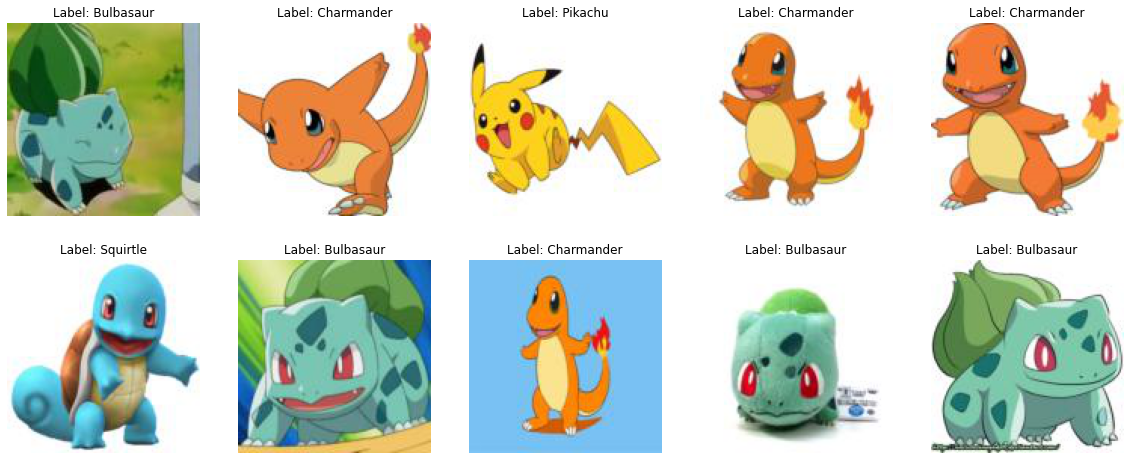

In [29]:
# Visualization of 10 random samples
num_samples = 10
rand_samples = np.random.choice(np.arange(len(X_train)), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
  idx_image = rand_samples[i]
  im = imread(os.path.join('pokemon_dataset/', X_train[idx_image]))
  label = y_train[idx_image]
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_title(f"Label: {label}")
  ax.axis('off')
  ax.imshow(im)
plt.show()

In [30]:
# This class is a DataGenerator, which is a way to load and augment images 
# in batches for image classification tasks. 

class DataGenerator(Sequence):
    def __init__(self, filepath, files, labels, batch_size=32, 
                 data_augmentation=None, shuffle=True, random_state=42):
        'Initialization'
        self.filepath = filepath
        self.files = files
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.data_augmentation = data_augmentation
        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * 
                               self.batch_size]
        files_batch = [self.files[k] for k in indexes]
        y = [self.labels[k] for k in indexes]
        # Generate data
        x = self.__data_generation(files_batch)
        return np.array(x), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __data_generation(self, files):
        imgs = []
        for img_file in files:
            img = imread(self.filepath + img_file)
            if self.data_augmentation:
                self.data_augmentation(img)
            imgs.append(img) 
        return imgs
    
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

In [31]:
# Since we have 4 classes we are going to have 4 neurons in the output layer, 
# one neuron for each class. So we need to modify our labels to be represented 
# as a vector of zeros except in the actual class will be a one. For instance, 
# Bulbasaur will be [1, 0, 0, 0]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df.label.values.reshape(-1, 1))
enc.categories_

y_train_enc = enc.transform(y_train.reshape(-1, 1)).toarray()
y_val_enc = enc.transform(y_val.reshape(-1, 1)).toarray()

print(f'Train set shape: {y_train_enc.shape}')
print(f'Validation set shape: {y_val_enc.shape}')

Train set shape: (469, 4)
Validation set shape: (53, 4)


In [32]:
def network(input_shape=(128, 128, 3), num_classes=4):
  # This is a simple convolution network of only 2 conv layers, 
  # since our dataset is small a big network can cause an overfitting

  inputs = Input(shape=input_shape)
  conv1 = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
  mp1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, kernel_size=(3, 3), activation="relu")(mp1)
  mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  flat1 = Flatten()(mp2)
  class1 = Dense(1024, activation='relu')(flat1)
  outputs = Dense(num_classes, activation='softmax')(class1)
  model = Model(inputs, outputs)
  return model

In [33]:
# Datagenerator for train and validation sets
datagen_train = DataGenerator(filepath='pokemon_dataset/', files=X_train, 
                              labels=y_train_enc)
datagen_val = DataGenerator(filepath='pokemon_dataset/', files=X_val, 
                            labels=y_val_enc, shuffle=False)

Training the network

In [34]:
tf_seed() # We set the seed to reproduce results

# Neural network
model = network(num_classes=num_classes)
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

# Training network
model_checkpoint = ModelCheckpoint('model_no_aug.h5', monitor="val_loss", 
                                   save_best_only=True)
csv_logger = CSVLogger('model_no_aug.csv', separator=",", append=False)

if not os.path.exists('model_no_aug.h5'):
  model.fit(datagen_train, validation_data=datagen_val, epochs=15, 
            callbacks=[model_checkpoint, csv_logger])
else:
  model = load_model('model_no_aug.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 57600)             0   

Let's visualize the behaviour of the newtwork during the training.

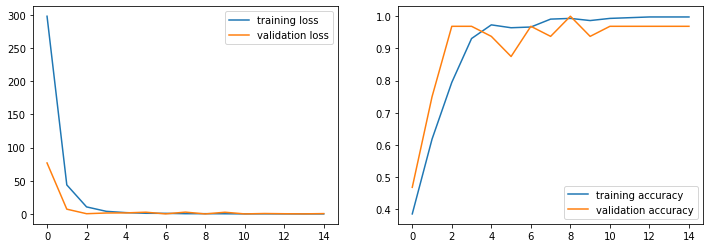

In [35]:
history_model = pd.read_csv('model_no_aug.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_model['epoch'].values, history_model['loss'].values, 
         label='training loss')
ax1.plot(history_model['epoch'].values, history_model['val_loss'].values, 
         label='validation loss')
ax1.legend()

ax2.plot(history_model['epoch'].values, history_model['accuracy'].values, 
         label='training accuracy')
ax2.plot(history_model['epoch'].values, history_model['val_accuracy'].values, 
         label='validation accuracy')
ax2.legend()

plt.show()

Let's visualize the output of a model given an image of the test set.

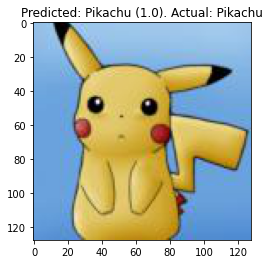

In [36]:
idx_pokemon = 7
x = imread(os.path.join('pokemon_dataset/', X_test[idx_pokemon]))

label = y_test[idx_pokemon]

y_hat = model.predict(np.expand_dims(x, axis=0))
y_hat_dec = enc.inverse_transform(y_hat)
y_hat_dec = np.squeeze(y_hat_dec)

probability = y_hat[0][np.argmax(y_hat)]

plt.imshow(x)
plt.title(f'Predicted: {y_hat_dec} ({probability}). Actual: {label}')
plt.show()

Let's check the results of the classification on the test set

In [37]:
x = np.array([imread(os.path.join('pokemon_dataset/', f)) for f in X_test])
predictions = model.predict(x)

y_hat_labels = np.zeros((y_test.shape[0], num_classes))
for idx, label in enumerate(np.argmax(predictions, axis=1)):
    y_hat_labels[idx, label] = 1

y_hat_dec = np.squeeze(enc.inverse_transform(y_hat_labels))

print(classification_report(y_test, y_hat_dec))

              precision    recall  f1-score   support

   Bulbasaur       1.00      0.87      0.93        15
  Charmander       0.73      0.85      0.79        13
     Pikachu       1.00      0.67      0.80        15
    Squirtle       0.75      1.00      0.86        15

    accuracy                           0.84        58
   macro avg       0.87      0.84      0.84        58
weighted avg       0.88      0.84      0.84        58



This is the confussion matrix of the results on the **test set** by means of a confusion matrix.

![confusion_matrix](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/practice3/images/confusion_matrix.png "confusion matrix")

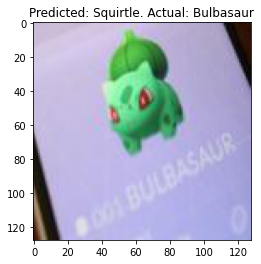

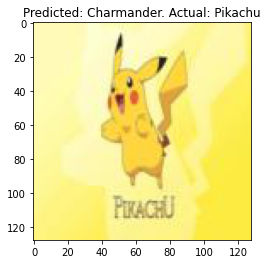

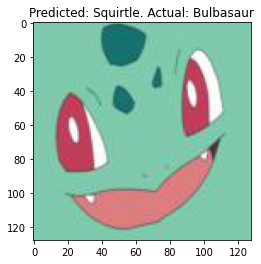

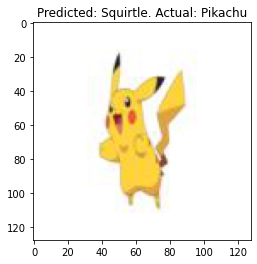

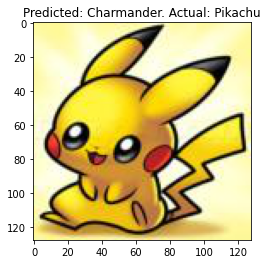

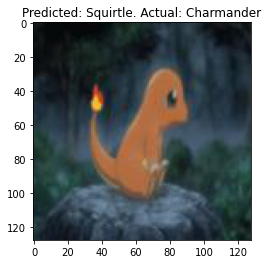

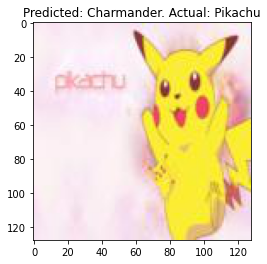

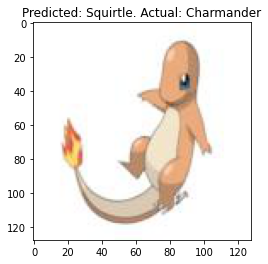

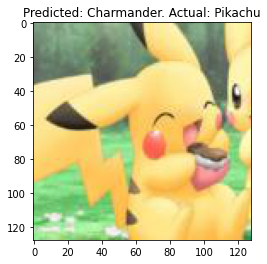

In [38]:
# Let's visualize some wrongly classified images 

wrongly_classified = np.where(y_test != y_hat_dec)

for i in wrongly_classified[0]:
  plt.imshow(x[i])
  plt.title(f'Predicted: {y_hat_dec[i]}. Actual: {y_test[i]}')
  plt.show()

# Tasks

### Data Augmentation

Here we are going to see the efffect of using data augmentation for image classification.

First, we you have to define function that performs an horizontal flipping, so the resulting image should looks like this:

![flipping](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/practice3/images/flipping.png "flipping")

Additionally, we will check a rotation of the image:

![rotating](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/practice3/images/rotating.png "rotating")



#### Horizontal flip

In [ ]:
# TODO: Define the libraries needed for performing the flipping

def horizontal_flip(image: np.array) -> np.array:
  # TODO: Create the function for flipping an image horizontally. 
  # Hint: Use the library numpy

  flipped_image = None
  return flipped_image

Let's visualize the result of your implementation (your image should looks like the showed before) 

In [ ]:
idx_pokemon = 0
im = imread(os.path.join('pokemon_dataset/', X_train[idx_pokemon]))
im_flipped = horizontal_flip(im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
ax1.imshow(im)
ax1.set_title('Original image')
ax2.imshow(im_flipped)
ax2.set_title('Flipped image')

plt.show()

#### Rotation

In [ ]:
# TODO: Define the libraries needed for performing the rotation

def rotation(image: np.array, angle: float) -> np.array:
  # TODO: Create the function for rotating an image given an angle. 
  # Hint: Use the library imutils
  
  rotated_image = None
  return rotated_image

Let's visualize the result of the your implementation for rotating an image (your image should looks like the showed before).


In [ ]:
idx_pokemon = 0
im = imread(os.path.join('pokemon_dataset/', X_train[idx_pokemon]))
im_rotated = rotation(im, 10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
ax1.imshow(im)
ax1.set_title('Original image')
ax2.imshow(im_rotated)
ax2.set_title('Rotated image')

plt.show()

In [ ]:
# This function will be used to randomly modify the images during training

def data_augmentation(image: np.array) -> np.array:
  p = random.random()
  if p > 0.5:
    image = horizontal_flip(image)
  p = random.random()
  if p > 0.5:
    angle = int(random.uniform(1, 10))
    p = random.random()
    if p > 0.5:
      angle = -angle 
      image = rotation(image, angle)
  return image

### Training

In [ ]:
# TODO: Run this cell

tf_seed() # We set the seed

# We add the data augmentation to the training data generator
datagen_train = DataGenerator(filepath='pokemon_dataset/', files=X_train, 
                              labels=y_train_enc, 
                              data_augmentation=data_augmentation)
datagen_val = DataGenerator(filepath='pokemon_dataset/', files=X_val, 
                            labels=y_val_enc, shuffle=False)

model_aug = network(num_classes=num_classes)
model_aug.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])
model_aug.summary()


model_aug_checkpoint = ModelCheckpoint('model_aug.h5', monitor="val_loss", 
                                   save_best_only=True)
csv_aug_logger = CSVLogger('model_aug.csv', separator=",", append=False)

model_aug.fit(datagen_train, validation_data=datagen_val, epochs=15, 
          callbacks=[model_aug_checkpoint, csv_aug_logger])

#### Results of the training

In [ ]:
history_model = pd.read_csv('model_aug.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_model['epoch'].values, history_model['loss'].values, 
         label='training loss')
ax1.plot(history_model['epoch'].values, history_model['val_loss'].values, 
         label='validation loss')
ax1.legend()

ax2.plot(history_model['epoch'].values, history_model['accuracy'].values, 
         label='training accuracy')
ax2.plot(history_model['epoch'].values, history_model['val_accuracy'].values, 
         label='validation accuracy')
ax2.legend()

plt.show()

Let's check the output of the trained model with one test image.

In [ ]:
idx_pokemon = 7
x = imread(os.path.join('pokemon_dataset/', X_test[idx_pokemon]))

label = y_test[idx_pokemon]

y_hat = model_aug.predict(np.expand_dims(x, axis=0))
y_hat_dec = enc.inverse_transform(y_hat)

plt.imshow(x)
plt.title(f'Predicted: {y_hat_dec[0][0]}. Actual: {label}')
plt.show()

Here are the results of the classification

In [ ]:
x = np.array([imread(os.path.join('pokemon_dataset/', f)) for f in X_test])
predictions = model_aug.predict(x)

y_hat_labels = np.zeros((y_test.shape[0], num_classes))
for idx, label in enumerate(np.argmax(predictions, axis=1)):
  y_hat_labels[idx, label] = 1

y_hat_dec = np.squeeze(enc.inverse_transform(y_hat_labels))

print(classification_report(y_test, y_hat_dec))

Let's check some images wrongly classified.

In [ ]:
wrongly_classified = np.where(y_test != y_hat_dec)

for i in wrongly_classified[0]:
  plt.imshow(x[i])
  plt.title(f'Predicted: {y_hat_dec[i]}. Actual: {y_test[i]}')
  plt.show()

In [ ]:
# TODO: In this cell write the code for showing the confusion matrix of 
# the model with data augmentsation on the test set
# Hint: Use the library scikit-learn

